## Part B3 - Hotel Pricing Analysis using Clustering Techniques

### Import Libraries & Data Loading

In [ ]:
# Data & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid") # Set seaborn style

# Clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# DATA LOADING - Load the updated dataset
df = pd.read_csv("Data/Hotels_data_Changed.csv")

### 3.1 - Top Hotels

We select the 150 hotels that appear most frequently in the dataset. This helps reduce noise and ensures the clustering focuses on popular hotels.


In [113]:
# Get the 150 most frequent hotel names
top_hotels = df['Hotel Name'].value_counts().head(150).index

# Filter the dataset to include only these top hotels
filterdf = df[df['Hotel Name'].isin(top_hotels)]

# Preview the filtered data
filterdf.head()

,Snapshot Date,Checkin Date,Days,Original Price,...,DayDiff,WeekDay,DiscountDiff,DiscountPerc
2,2015-07-17,2015-08-13,5,4370,...,27,Thursday,130,2.974828
3,2015-07-17,2015-07-26,5,1739,...,9,Sunday,72,4.140311
4,2015-07-17,2015-08-12,5,1739,...,26,Wednesday,67,3.852789
5,2015-07-17,2015-08-07,5,1436,...,21,Friday,91,6.337047
6,2015-07-17,2015-08-09,5,1616,...,23,Sunday,91,5.631188


### 3.2 - Top Check-In Dates

We select the 40 most frequent check-in dates from the filtered hotel data. This ensures that the clustering is based on dates with sufficient data points.

In [114]:
# Get the 40 most frequent check-in dates
top_checkin_dates = filterdf['Checkin Date'].value_counts().head(40).index

# Filter the dataset to include only these top check-in dates
filtered_by_date = filterdf[filterdf['Checkin Date'].isin(top_checkin_dates)]

# Preview the result
filtered_by_date.head()

,Snapshot Date,Checkin Date,Days,Original Price,...,DayDiff,WeekDay,DiscountDiff,DiscountPerc
2,2015-07-17,2015-08-13,5,4370,...,27,Thursday,130,2.974828
4,2015-07-17,2015-08-12,5,1739,...,26,Wednesday,67,3.852789
7,2015-07-17,2015-08-12,5,1256,...,26,Wednesday,73,5.812102
8,2015-07-17,2015-08-13,5,1256,...,27,Thursday,55,4.378981
29,2015-07-17,2015-08-12,5,3763,...,26,Wednesday,385,10.231199


### 3.3 - Pivot Discount Price Matrix 

The goal of this step was to reshape the data so that each hotel is represented by a single row with structured features suitable for clustering.  
As requested, we first aggregated the data by finding the minimum discount price for each combination of hotel, check-in date, and discount code.  <br>
This allowed us to focus on the most attractive offer available for each scenario, which reflects realistic booking behavior. <br><br>
Next, we pivoted the table: each row corresponds to a hotel, and each column corresponds to a specific check-in date and discount code.  
To ensure a consistent structure, we created a fixed column layout (40 dates × 4 discount codes = 160 features), even if some hotels lacked certain values.  <br>
Missing combinations were filled with -1 to distinguish them from real prices and to maintain uniformity across all rows.  
Finally, we flattened the column names into a readable format and reset the index to finalize the feature matrix, ready for clustering analysis.

In [115]:
# Aggregate: get the lowest discount price for each (hotel, checkin date, discount code)
grouped_prices = (
    filtered_by_date
    .groupby(['Hotel Name', 'Checkin Date', 'Discount Code'])['Discount Price']
    .min()
    .reset_index()
)

# Pivot the table: rows = hotels, columns = (date + code), values = price
pivot_matrix = grouped_prices.pivot_table(
    index='Hotel Name',
    columns=['Checkin Date', 'Discount Code'],
    values='Discount Price',
    aggfunc='first'
)

# Create full column structure (40 dates × 4 discount codes)
columns_index = pd.MultiIndex.from_product(
    [top_checkin_dates, [1, 2, 3, 4]],
    names=['Checkin Date', 'Discount Code']
)

# Reindex and fill missing values with -1
pivot_matrix = pivot_matrix.reindex(columns=columns_index, fill_value=-1).fillna(-1)

# Flatten the multi-index columns into string format: "YYYY-MM-DD - Code"
pivot_matrix.columns = [
    f"{col[0]} - {col[1]}" if isinstance(col, tuple) else col
    for col in pivot_matrix.columns
]

# Reset index to turn hotel names into a column
pivot_matrix = pivot_matrix.reset_index()

# Preview the result
print("Total lines (hotels) included:", pivot_matrix.shape[0])
print("Total columns (price per check-in date + discount code):", pivot_matrix.shape[1])
pd.set_option('display.max_columns', 8) # shows first 4 and last 4 columns
pivot_matrix.head()

Total lines (hotels) included: 149
Total columns (price per check-in date + discount code): 161


,Hotel Name,2015-11-11 - 1,2015-11-11 - 2,2015-11-11 - 3,...,2015-11-25 - 1,2015-11-25 - 2,2015-11-25 - 3,2015-11-25 - 4
0,Aloft Harlem,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0
1,Andaz 5th Avenue - a concept by Hyatt,-1.0,1982.0,2375.0,...,-1.0,1502.0,2103.0,2103.0
2,Andaz Wall Street - a concept by Hyatt,1078.0,1305.0,1430.0,...,1013.0,1029.0,990.0,-1.0
3,Baccarat Hotel and Residences New York,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0
4,Bentley Hotel,-1.0,-1.0,-1.0,...,-1.0,2023.0,2041.0,-1.0


#### Check for Missing Hotels  

We verified whether any of the top 150 hotels were missing from the pivoted matrix.  
If a hotel is missing but still has check-in records, it may indicate an issue in the preprocessing pipeline.

In [116]:
# Check if any of the top hotels are missing from the pivoted matrix
miss = list(set(top_hotels) - set(pivot_matrix['Hotel Name']))
print("Missing hotel(s):", miss)

# Look for their original data in the filtered dataset
has_records = False

for name in miss:
    hotel_data = filtered_by_date[filtered_by_date['Hotel Name'] == name]
    if not hotel_data.empty:
        has_records = True
        print(f"\nRecords found for missing hotel '{name}':")

# Final message
if has_records:
    print("\n⚠️ Some missing hotels still have check-in records — check your processing pipeline.")
else:
    print("\n✅ All missing hotels have no records in the selected check-in dates — everything is valid.")


Missing hotel(s): ['Embassy Suites Newark Airport']

✅ All missing hotels have no records in the selected check-in dates — everything is valid.


### 3.4 - Normalize Discount Prices

We normalized the price data for each hotel individually, scaling valid values to a 0–100 range where 0 is the hotel's lowest price and 100 is its highest.  
This ensures that clustering is based on price patterns rather than absolute values, while keeping missing values (-1) unchanged.


In [117]:
# Normalize prices per hotel: 0 = min, 100 = max, ignoring -1
def normalize(prices):
    valid_prices = prices[prices != -1]
    if valid_prices.empty:
        return prices
    min_val, max_val = valid_prices.min(), valid_prices.max()
    if min_val == max_val:
        return prices.mask(prices != -1, 0)
    scaled = ((prices - min_val) / (max_val - min_val) * 100).round(0)
    return scaled.where(prices != -1, -1).astype("Int64")

# Apply normalization to each hotel (row)
normalized_prices = pivot_matrix.drop(columns='Hotel Name').apply(normalize, axis=1)

# Preview the normalized result
normalized_prices.head()

,2015-11-11 - 1,2015-11-11 - 2,2015-11-11 - 3,2015-11-11 - 4,...,2015-11-25 - 1,2015-11-25 - 2,2015-11-25 - 3,2015-11-25 - 4
0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0
1,-1.0,40.0,65.0,-1.0,...,-1.0,10.0,48.0,48.0
2,6.0,19.0,26.0,-1.0,...,2.0,3.0,1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,...,-1.0,55.0,55.0,-1.0


### 3.5 - Finalize Normalized Matrix  

We created the final matrix by attaching hotel names to the normalized price features, preparing a clean dataset for clustering.  
The result was saved to a CSV file, ensuring it contains all hotels and the expected number of feature columns.


In [ ]:
# Create normalized matrix and add hotel names
normalized_matrix = normalized_prices.copy()
normalized_matrix.insert(0, 'Hotel Name', pivot_matrix['Hotel Name'])

# Save to CSV for clustering
normalized_matrix.to_csv("Data/hotels_clustering_data.csv", index=False)

# Checking if: (149, 161)
print("Normalized matrix shape:", normalized_matrix.shape)  

Normalized matrix shape: (149, 161)


### 3.6 - Hierarchical Clustering Analysis

In this final step, we were asked to apply a clustering method on the normalized hotel price matrix in order to group similar hotels based on their price patterns.  
The main goal was to uncover hidden structures in the data and identify groups of hotels that behave similarly in terms of pricing across check-in dates and discount codes.  

To achieve this, we used **hierarchical clustering** with **Ward’s linkage method**, which is well-suited for detecting compact, well-separated clusters.  
The analysis was carried out in three parts:
- First, we generated a **dendrogram** to visualize the hierarchical relationships between hotels and observe possible cluster separations.
- Then, we selected a fixed number of clusters (**k=5**) and visualized the distribution of hotels across these clusters using a color-coded bar chart.
- Lastly, we explored the effect of different **distance thresholds** on the dendrogram, showing how the number and shape of clusters change as we adjust the threshold.

This analysis helps reveal how hotels can be grouped based on discounting strategies and pricing behavior, and serves as the foundation for drawing meaningful business insights.


#### 3.6.1 - Dendrogram Creation and Structure Observation 

We removed the hotel names and performed hierarchical clustering using the normalized price data.  
The dendrogram we generated showed a clear structure with several natural breakpoints, suggesting that the hotels can be meaningfully grouped based on pricing behavior.  
This visual helped us decide how many clusters to use in the next step and confirmed that the data contains visible patterns.


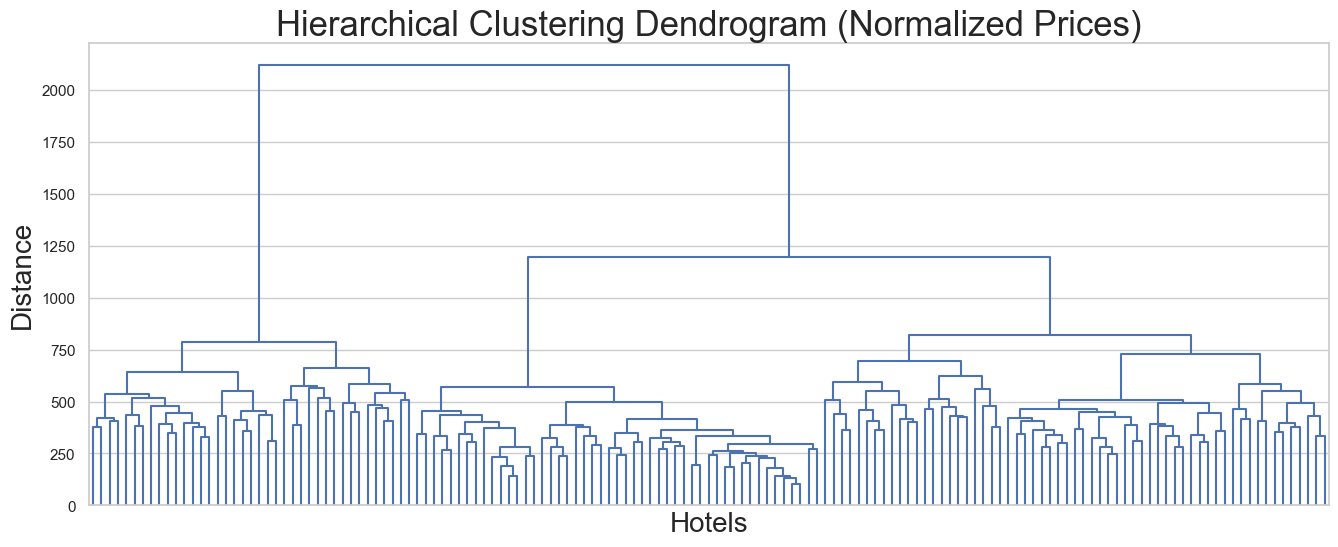

In [119]:
# Prepare the data (remove hotel name)
clustering_data = normalized_matrix.drop(columns='Hotel Name').values

# Compute linkage matrix using Ward method
Z = linkage(clustering_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(16, 6))
dendrogram(Z, no_labels=True, color_threshold=0)
plt.title("Hierarchical Clustering Dendrogram (Normalized Prices)", fontsize=25)
plt.xlabel("Hotels", fontsize=20)
plt.ylabel("Distance", fontsize=20)
plt.grid(True)
plt.show()


#### 3.6.2 - Cluster Assignment and Distribution Analysis  
After assigning each hotel to one of five clusters based on their normalized price patterns, we analyzed the distribution of hotels across clusters.  
The bar chart visualization revealed several key observations:

- The distribution is unbalanced — one or two clusters contain the majority of hotels, while others are much smaller.  
- This indicates that many hotels exhibit similar pricing behaviors and can be grouped together confidently.  
- Smaller clusters likely represent hotels with distinct or uncommon discount strategies, possibly targeting niche audiences.  
- The presence of such clusters highlights variability in market behavior, and may be useful for identifying outlier hotels or unique pricing tactics.

This step helped us understand the overall structure of the dataset and served as a starting point for deeper cluster interpretation.


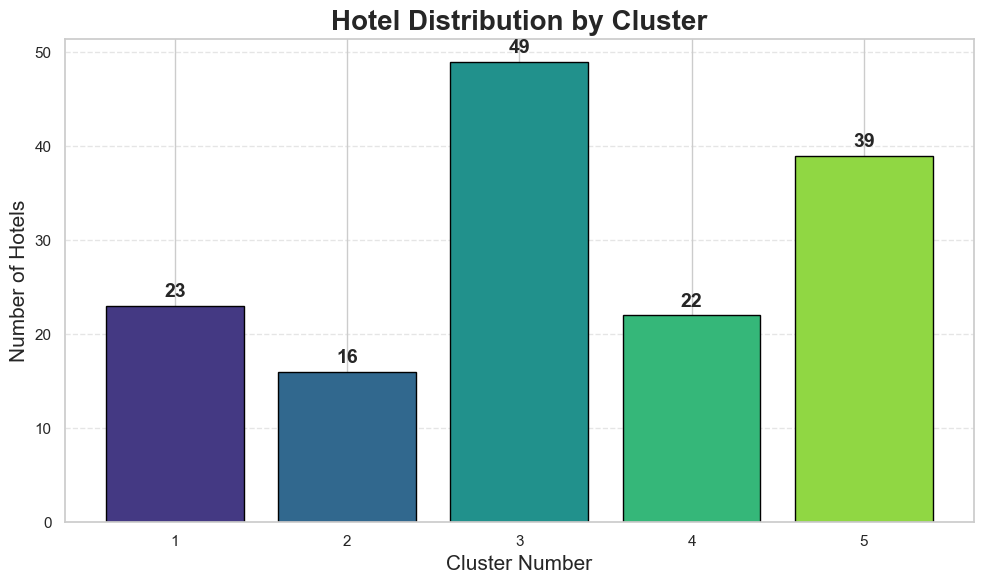

In [120]:
# Assign each hotel to a cluster (e.g., 5 clusters)
clusters = fcluster(Z, t=5, criterion='maxclust')

# Create a DataFrame with hotel names and their assigned cluster
hotel_clusters = pd.DataFrame({
    'Hotel Name': normalized_matrix['Hotel Name'],
    'Cluster': clusters
})

# Count the number of hotels per cluster
cluster_counts = hotel_clusters['Cluster'].value_counts().sort_index()

# Define colors using a color palette
num_clusters = cluster_counts.shape[0]
colors = sns.color_palette("viridis", num_clusters)

# Plot the styled bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color=colors, edgecolor='black')

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height),
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Enhance plot styling
plt.title("Hotel Distribution by Cluster", fontsize=20, fontweight='bold')
plt.xlabel("Cluster Number", fontsize=15)
plt.ylabel("Number of Hotels", fontsize=15)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### 3.6.3 - Threshold Comparison and Subgroup Insights  

We explored how changing the dendrogram’s color threshold affects the way hotels are grouped into clusters.  
This helped us better understand the stability of patterns and the point at which meaningful differences begin to emerge.

- At higher thresholds, clusters appear larger and more generalized, showing broad similarities but hiding fine details.  
- As we lowered the threshold, we began to see more specific divisions, especially in clusters that were previously large and uniform.  
- Some hotels consistently stayed grouped together across thresholds, indicating strong similarity and potentially shared pricing logic or strategy.  
- Others split off early, suggesting distinct behaviors or unique discounting models that separate them from the majority.  
- This comparison highlighted which hotels follow predictable pricing patterns and which deviate, giving us a clearer view of market diversity.

This part allowed us to reflect on how sensitive our clustering is to threshold selection, and where the data reveals hidden complexity.


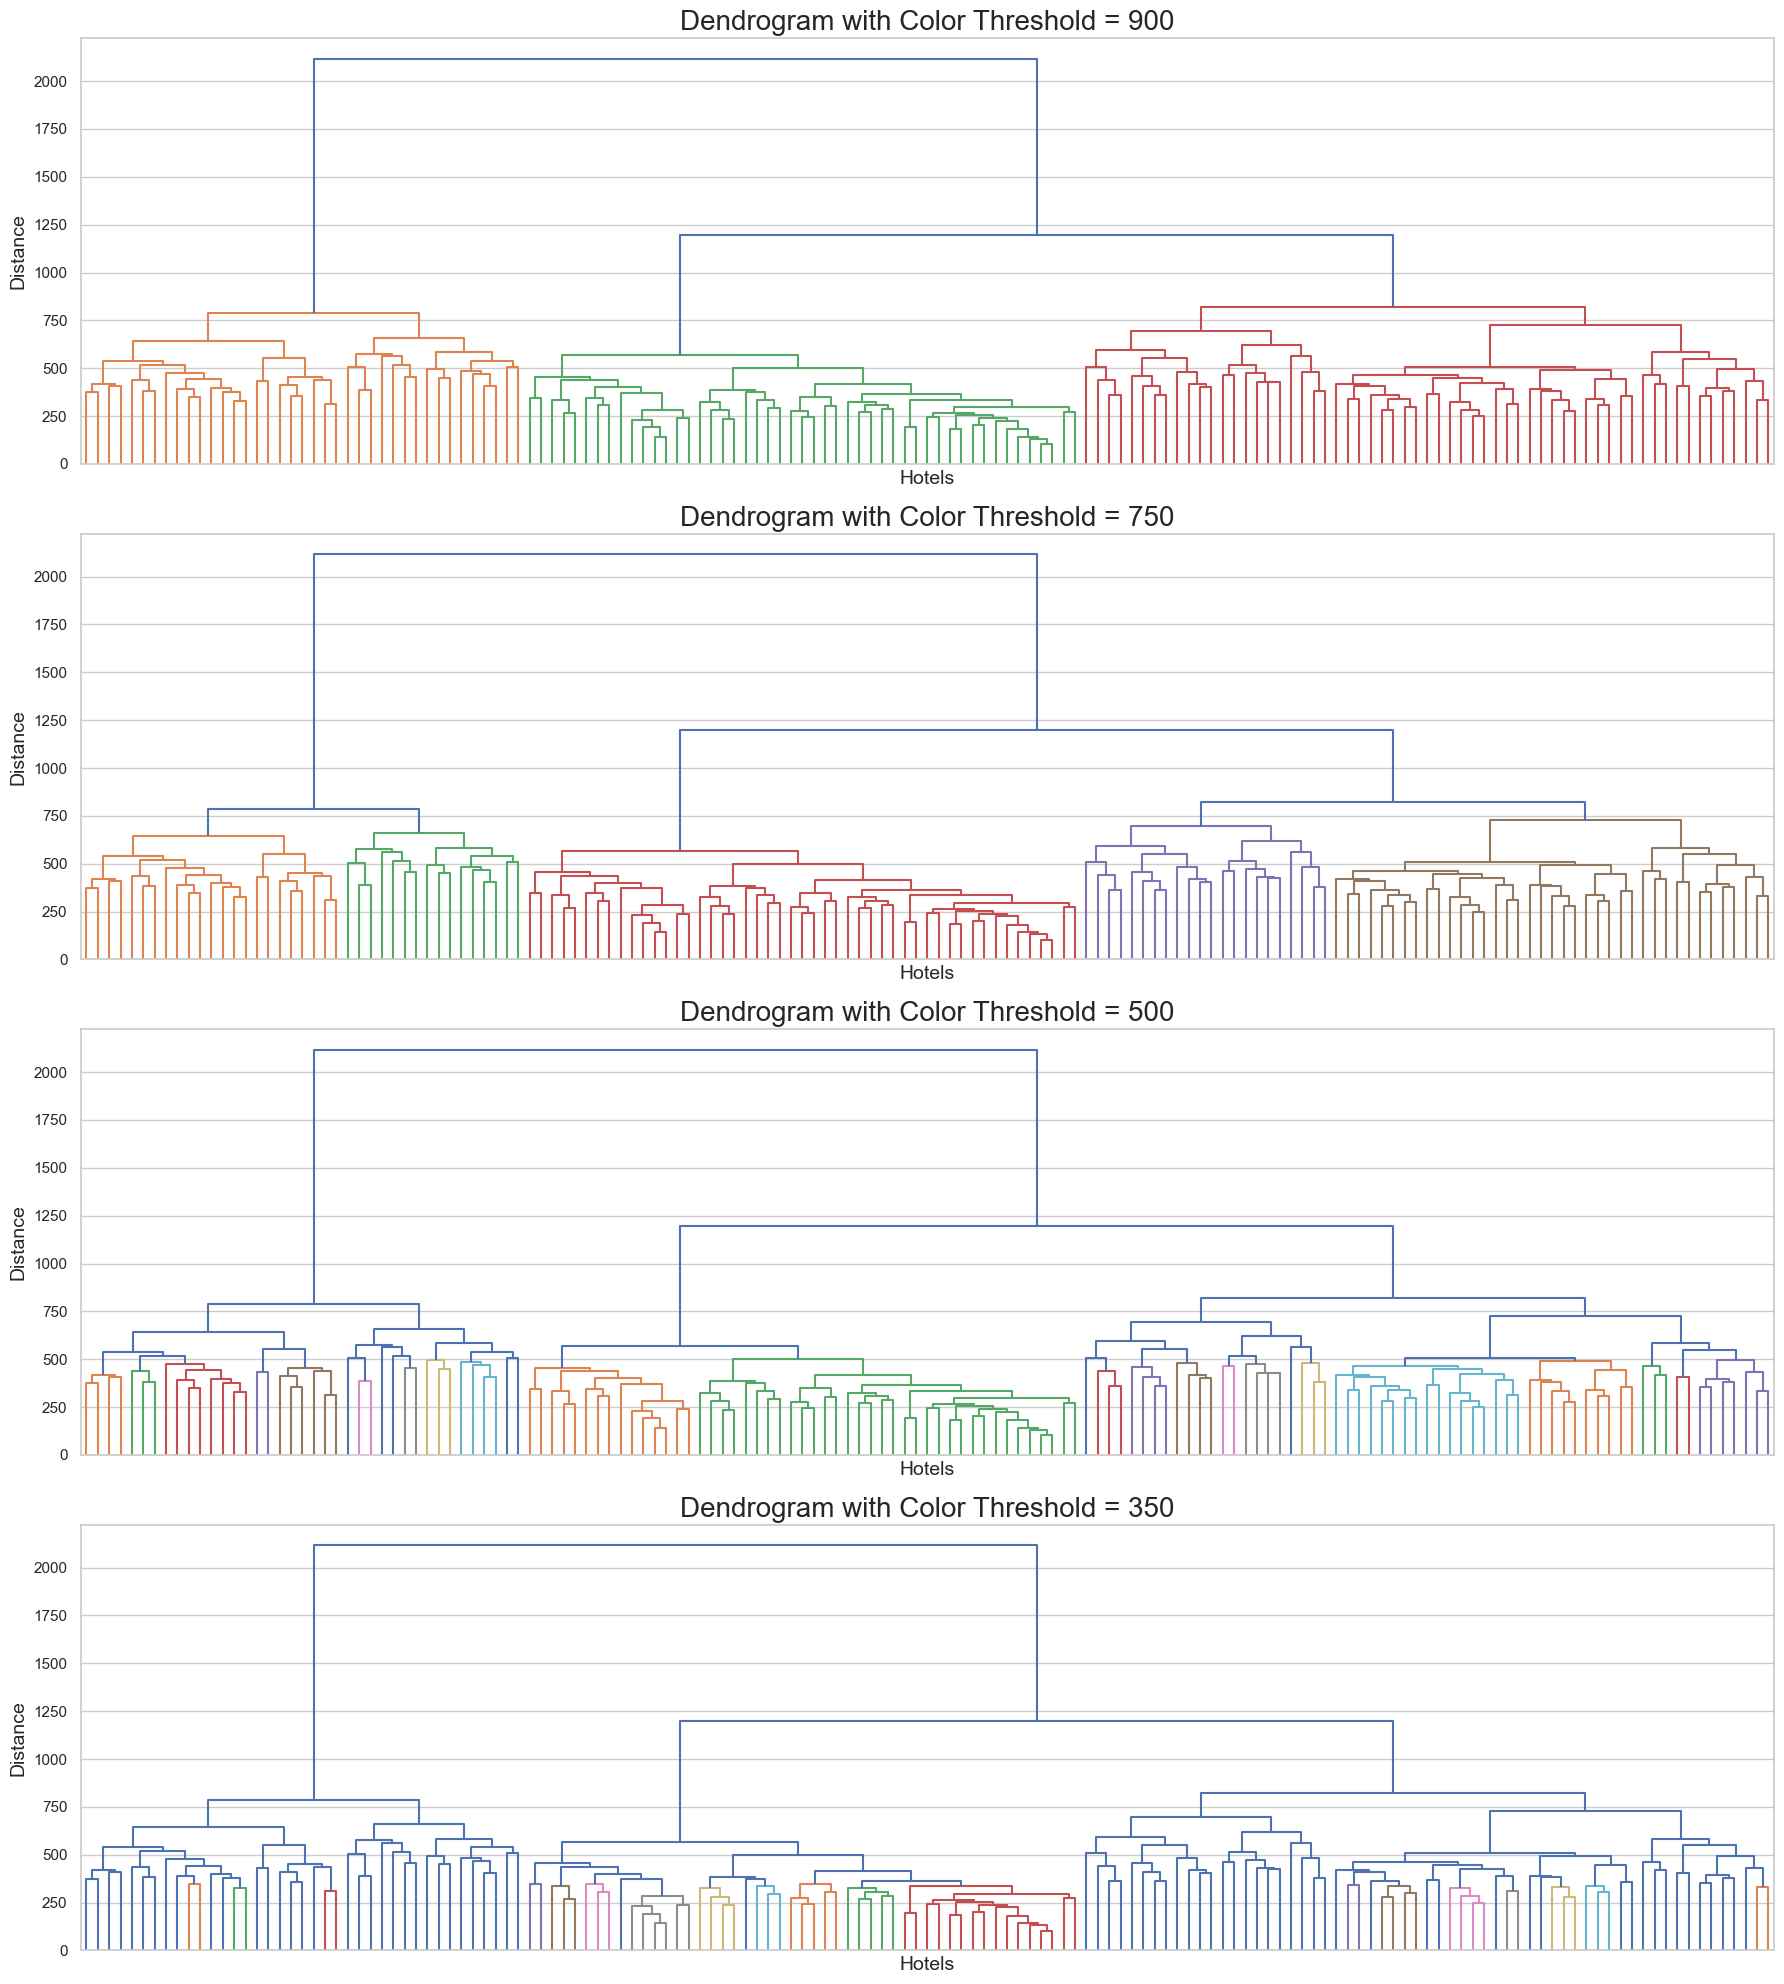

In [ ]:
# Load normalized matrix
normalized_matrix = pd.read_csv("Data/hotels_clustering_data.csv")

# Prepare clustering data (remove hotel names)
clustering_data = normalized_matrix.drop(columns='Hotel Name').values

# Compute the linkage matrix using Ward's method
Z = linkage(clustering_data, method='ward')

# Define color thresholds for comparison
thresholds = [900, 750, 500, 350]    # upping 150 each time

# Plot dendrograms for different thresholds
fig, axes = plt.subplots(len(thresholds), 1, figsize=(18, 5 * len(thresholds)))

for i, threshold in enumerate(thresholds):
    dendrogram(
        Z,
        no_labels=True,
        color_threshold=threshold,
        ax=axes[i]
    )
    axes[i].set_title(f"Dendrogram with Color Threshold = {threshold}", fontsize=20)
    axes[i].set_xlabel("Hotels", fontsize=14)
    axes[i].set_ylabel("Distance", fontsize=14)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Summary of Part B3

In this section, we conducted a complete clustering pipeline on hotel price data, aiming to uncover meaningful groups based on discount behavior over time.  
We began by filtering the dataset to focus on the most frequent hotels and check-in dates, ensuring the analysis relied on sufficient data points.

We then reshaped the data into a structured matrix where each hotel was represented by 160 normalized features, capturing the lowest discount price per date and code.  
After validating that no important data was lost in preprocessing, we scaled the prices per hotel to a 0–100 range to remove bias from absolute values.

This prepared dataset was used for hierarchical clustering, which revealed clear groupings of hotels based on discount strategies.  
We explored different cluster structures by adjusting thresholds and visualizing the results both as dendrograms and bar charts.  
This allowed us to identify common pricing patterns, outlier behaviors, and levels of similarity between hotels.

Overall, this analysis gave us a deeper understanding of how hotels differentiate themselves in terms of pricing.  
It also provided a solid foundation for future segmentation, competitive analysis, or pricing strategy refinement.  
<br>
**These insights naturally lead into Part B4, where we explore how additional hotel attributes correlate with the discovered clusters.**
